# Graph Neural Network for Human vs LLM Code Classification

This notebook implements a GIN (Graph Isomorphism Network) to distinguish between human-written and LLM-generated Python code using Abstract Syntax Tree (AST) representations.

## 1. Setup and Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve


In [2]:
# Import custom modules
from graphdataset import CodeGraphDataset
from process import PythonCodeProcessor

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Data Loading and Exploration

In [5]:
# Configuration
DATA_DIR = 'dataset/python'
VALID_FILE = os.path.join(DATA_DIR, 'valid_no_comment.jsonl')
TEST_FILE = os.path.join(DATA_DIR, 'test_no_comment.jsonl')

MAX_NODES = 500  # Maximum nodes in AST
EMBEDDING_SIZE = 128  # Dimension of node embeddings
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
HIDDEN_DIM = 256
NUM_LAYERS = 5

# NEW: Optimization parameters
MAX_SAMPLES_TRAIN = 100  # Limit training samples (None = all)
MAX_SAMPLES_TEST = 100   # Limit test samples (None = all)
TIMEOUT_MINUTES = 200      # Stop processing after 10 minutes

print("Configuration:")
print(f"  Max nodes: {MAX_NODES}")
print(f"  Embedding size: {EMBEDDING_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  GIN layers: {NUM_LAYERS}")
print(f"  Max training samples: {MAX_SAMPLES_TRAIN}")
print(f"  Max test samples: {MAX_SAMPLES_TEST}")
print(f"  Timeout: {TIMEOUT_MINUTES} minutes")



Configuration:
  Max nodes: 500
  Embedding size: 128
  Batch size: 64
  Learning rate: 0.001
  Epochs: 30
  Hidden dim: 256
  GIN layers: 5
  Max training samples: 100
  Max test samples: 100
  Timeout: 200 minutes


In [6]:
# Load datasets with limits and timeout
print("\n" + "="*70)
print("Loading validation dataset...")
print("="*70)
valid_dataset = CodeGraphDataset(
    jsonl_path=VALID_FILE,
    max_nodes=MAX_NODES,
    embedding_size=EMBEDDING_SIZE,
    force_reprocess=True,
    max_samples=MAX_SAMPLES_TRAIN,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print("\n" + "="*70)
print("Loading test dataset (sharing vocabulary)...")
print("="*70)
test_dataset = CodeGraphDataset(
    jsonl_path=TEST_FILE,
    processor=valid_dataset.processor,  # Share vocabulary
    max_nodes=MAX_NODES,
    max_samples=MAX_SAMPLES_TEST,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print(f"\n{'='*70}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"{'='*70}")


Loading validation dataset...
Processing graphs from dataset/python/valid_no_comment.jsonl
  Limiting to 100 samples
  Timeout: 200 minutes
Loaded 100 examples from dataset/python/valid_no_comment.jsonl
Extracting AST node sequences from corpus...


Extracting tokens:   0%|          | 0/1 [00:00<?, ?batch/s]

Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 11)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Extracting tokens: 100%|██████████| 1/1 [00:20<00:00, 20.02s/batch]


Total token sequences for embedding: 199
Training Word2Vec embeddings on AST tokens...
Vocabulary size: 506
Processing code into graphs...


Processing samples:   3%|▎         | 3/100 [00:02<01:20,  1.20sample/s]

Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))


Processing samples:  54%|█████▍    | 54/100 [00:42<00:34,  1.35sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 11)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Processing samples: 100%|██████████| 100/100 [01:21<00:00,  1.23sample/s]


Successfully processed 97 examples
Failed to process 3 examples
Saving to cache: dataset/python/cached_graphs/valid_no_comment_n100_graphs.pkl
Cache saved successfully

Loading test dataset (sharing vocabulary)...
Processing graphs from dataset/python/test_no_comment.jsonl
  Limiting to 100 samples
  Timeout: 200 minutes
Loaded 100 examples from dataset/python/test_no_comment.jsonl
Processing code into graphs...


Processing samples:  34%|███▍      | 34/100 [00:26<00:49,  1.34sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 5)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Processing samples: 100%|██████████| 100/100 [01:20<00:00,  1.24sample/s]


Successfully processed 98 examples
Failed to process 2 examples
Saving to cache: dataset/python/cached_graphs/test_no_comment_n100_graphs.pkl
Cache saved successfully

Validation set size: 97
Test set size: 98


In [7]:
# Display dataset statistics
print("\n" + "="*70)
print("VALIDATION DATASET STATISTICS")
print("="*70)
valid_stats = valid_dataset.get_stats()
for key, value in valid_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*70)
print("TEST DATASET STATISTICS")
print("="*70)
test_stats = test_dataset.get_stats()
for key, value in test_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")


VALIDATION DATASET STATISTICS
total_samples: 97
avg_code_nodes: 61.72
max_code_nodes: 241
min_code_nodes: 3
avg_contrast_nodes: 76.15
max_contrast_nodes: 412
min_contrast_nodes: 3
label_distribution: {'label_0': 36, 'label_1': 61}

TEST DATASET STATISTICS
total_samples: 98
avg_code_nodes: 75.87
max_code_nodes: 326
min_code_nodes: 3
avg_contrast_nodes: 72.96
max_contrast_nodes: 381
min_contrast_nodes: 5
label_distribution: {'label_0': 44, 'label_1': 54}


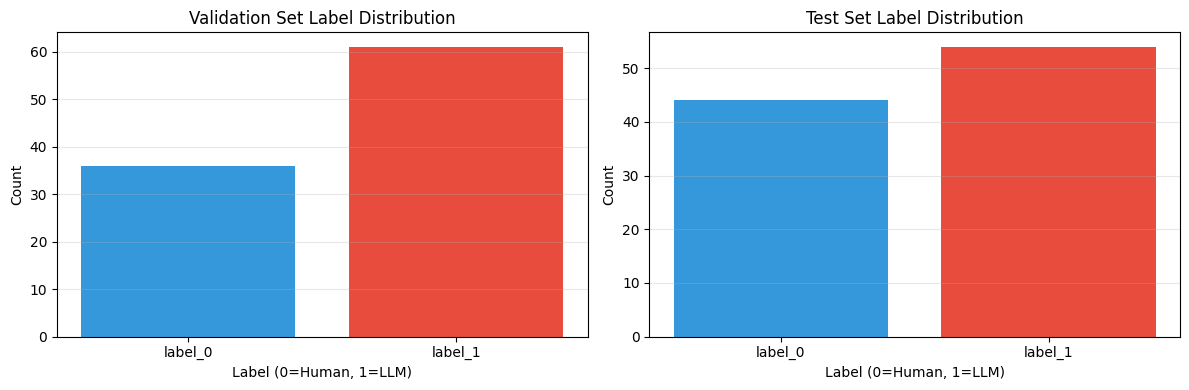

In [8]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Validation set
valid_labels = valid_stats['label_distribution']
axes[0].bar(valid_labels.keys(), valid_labels.values(), color=['#3498db', '#e74c3c'])
axes[0].set_title('Validation Set Label Distribution')
axes[0].set_xlabel('Label (0=Human, 1=LLM)')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Test set
test_labels = test_stats['label_distribution']
axes[1].bar(test_labels.keys(), test_labels.values(), color=['#3498db', '#e74c3c'])
axes[1].set_title('Test Set Label Distribution')
axes[1].set_xlabel('Label (0=Human, 1=LLM)')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Examine a sample
sample = valid_dataset[0]
print("\n" + "="*70)
print("SAMPLE DATA POINT")
print("="*70)
print(f"Index: {sample['index']}")
print(f"Label: {sample['label'].item()} ({'Human' if sample['label'].item() == 0 else 'LLM'})")
print(f"\nCode Graph:")
print(f"  Shape: {sample['code_graph'].shape}")
print(f"  Number of nodes: {sample['code_num_nodes']}")
print(f"  Sequence length: {len(sample['code_sequence'])}")
print(f"  First 15 tokens: {sample['code_sequence'][:15]}")
print(f"\nContrast Graph:")
print(f"  Shape: {sample['contrast_graph'].shape}")
print(f"  Number of nodes: {sample['contrast_num_nodes']}")
print(f"  Sequence length: {len(sample['contrast_sequence'])}")
print(f"  First 15 tokens: {sample['contrast_sequence'][:15]}")


SAMPLE DATA POINT
Index: gp266290
Label: 1 (LLM)

Code Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 13
  Sequence length: 13
  First 15 tokens: [12, 8, 5, 1, 4, 3, 1, 0, 1, 0, 10, 1, 0]

Contrast Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 60
  Sequence length: 60
  First 15 tokens: [12, 8, 9, 3, 2, 1, 0, 0, 3, 2, 266, 0, 1, 0, 5]


In [10]:
# Get embedding matrix
embedding_matrix = valid_dataset.get_embedding_matrix()
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")
print(f"Vocabulary size: {embedding_matrix.shape[0] - 1}")


Embedding matrix shape: torch.Size([507, 128])
Vocabulary size: 506


## 3. GIN Model Architecture

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GINLayer(nn.Module):
    """Graph Isomorphism Network Layer.
    
    Implements: h_v^(k) = MLP^(k)((1 + epsilon^(k)) * h_v^(k-1) + sum_{u in N(v)} h_u^(k-1))
    """
    def __init__(self, input_dim, hidden_dim, output_dim, eps_learnable=True):
        super(GINLayer, self).__init__()
        
        # MLP for node update
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU()
        )
        
        # Learnable epsilon parameter
        if eps_learnable:
            self.eps = nn.Parameter(torch.zeros(1))
        else:
            self.register_buffer('eps', torch.zeros(1))
    
    def forward(self, x, adj):
        """
        Args:
            x: Node features [batch_size, num_nodes, feature_dim]
            adj: Adjacency matrix [batch_size, num_nodes, num_nodes]
        
        Returns:
            Updated node features [batch_size, num_nodes, output_dim]
        """
        # Extract dimensions FIRST (critical!)
        batch_size, num_nodes, feature_dim = x.size()
        
        # Aggregate neighbor features: sum_{u in N(v)} h_u
        neighbor_sum = torch.bmm(adj, x)  # [batch_size, num_nodes, feature_dim]
        
        # Remove self-loop from aggregation (we'll add it back with epsilon)
        # Create diagonal mask for each batch
        eye = torch.eye(num_nodes, device=adj.device).unsqueeze(0).expand(batch_size, -1, -1)
        self_features = torch.bmm(eye, x)
        neighbor_sum = neighbor_sum - self_features
        
        # Apply GIN update rule: (1 + eps) * h + sum(neighbors)
        out = (1 + self.eps) * x + neighbor_sum
        
        # Apply MLP
        out = out.view(batch_size * num_nodes, feature_dim)
        out = self.mlp(out)
        out = out.view(batch_size, num_nodes, -1)
        
        return out


class GINNetwork(nn.Module):
    """Graph Isomorphism Network for code classification."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(GINNetwork, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Optionally freeze embeddings
            # self.embedding.weight.requires_grad = False
        
        # GIN layers
        self.gin_layers = nn.ModuleList()
        
        # First layer
        self.gin_layers.append(
            GINLayer(embedding_dim, hidden_dim, hidden_dim, eps_learnable=True)
        )
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.gin_layers.append(
                GINLayer(hidden_dim, hidden_dim, hidden_dim, eps_learnable=True)
            )
        
        # Readout MLP (for graph-level classification)
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_layers, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, sequences, adj_matrices, num_nodes_list):
        """
        Args:
            sequences: LIST of token sequences (Python lists!)
            adj_matrices: Adjacency matrices [batch_size, max_nodes, max_nodes]
            num_nodes_list: List of actual number of nodes
        
        Returns:
            logits: [batch_size, num_classes]
        """
        batch_size = adj_matrices.size(0)
        max_nodes = adj_matrices.size(1)
        
        # FIX: Convert list of sequences to padded tensor, aligned with actual node counts
        node_features = torch.zeros(batch_size, max_nodes, dtype=torch.long, 
                                    device=adj_matrices.device)
        
        for i, seq in enumerate(sequences):
            # Get actual number of nodes for this graph
            num_nodes = num_nodes_list[i]
            # Use min of sequence length and actual nodes to align features with graph structure
            seq_len = min(len(seq), num_nodes)
            # Convert sequence to tensor and pad/truncate to match actual node count
            seq_tensor = torch.tensor(seq[:seq_len], dtype=torch.long, device=adj_matrices.device)
            # Pad with zeros (padding_idx=0) if sequence is shorter than num_nodes
            if seq_len < num_nodes:
                padding = torch.zeros(num_nodes - seq_len, dtype=torch.long, device=adj_matrices.device)
                seq_tensor = torch.cat([seq_tensor, padding])
            node_features[i, :num_nodes] = seq_tensor
        
        # Embed tokens
        x = self.embedding(node_features)
        
        # Apply GIN layers
        layer_outputs = []
        for layer in self.gin_layers:
            x = layer(x, adj_matrices)
            x = F.dropout(x, p=self.dropout, training=self.training)
            layer_outputs.append(x)
        
        # Graph-level readout with masking
        graph_representations = []
        for layer_out in layer_outputs:
            mask = torch.zeros(batch_size, max_nodes, 1, device=layer_out.device)
            for i, num_nodes in enumerate(num_nodes_list):
                mask[i, :num_nodes, :] = 1.0
            
            masked_out = layer_out * mask
            graph_rep = masked_out.sum(dim=1)
            graph_representations.append(graph_rep)
        
        # Concatenate and classify
        graph_rep = torch.cat(graph_representations, dim=1)
        logits = self.readout(graph_rep)
        
        return logits


class SiameseGNN(nn.Module):
    """Siamese network for comparing code and contrast samples."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(SiameseGNN, self).__init__()
        
        # Shared GNN encoder
        self.gnn = GINNetwork(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=hidden_dim * num_layers,  # Output embedding instead of class
            dropout=dropout,
            pretrained_embeddings=pretrained_embeddings
        )
        
        # Classifier on combined representations
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * num_layers * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, code_seq, code_adj, code_num_nodes,
                contrast_seq, contrast_adj, contrast_num_nodes):
        """
        Args:
            code_seq: Token sequences for code [batch_size, max_seq_len]
            code_adj: Adjacency matrices for code [batch_size, max_nodes, max_nodes]
            code_num_nodes: Number of nodes for each code graph [batch_size]
            contrast_seq: Token sequences for contrast [batch_size, max_seq_len]
            contrast_adj: Adjacency matrices for contrast [batch_size, max_nodes, max_nodes]
            contrast_num_nodes: Number of nodes for each contrast graph [batch_size]
        
        Returns:
            logits: [batch_size, num_classes]
        """
        # Encode both graphs
        code_embedding = self.gnn(code_seq, code_adj, code_num_nodes)
        contrast_embedding = self.gnn(contrast_seq, contrast_adj, contrast_num_nodes)
        
        # Concatenate embeddings
        combined = torch.cat([code_embedding, contrast_embedding], dim=1)
        
        # Classify
        logits = self.classifier(combined)
        
        return logits


print("GIN Model Architecture defined successfully!")

GIN Model Architecture defined successfully!


## 4. Training Setup

In [12]:
def collate_code_batch(batch):
    """Custom collate function to handle variable-length sequences."""
    indices = [item['index'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])
    code_graphs = torch.stack([item['code_graph'] for item in batch])
    contrast_graphs = torch.stack([item['contrast_graph'] for item in batch])
    code_num_nodes = [item['code_num_nodes'] for item in batch]
    contrast_num_nodes = [item['contrast_num_nodes'] for item in batch]
    code_sequences = [item['code_sequence'] for item in batch]
    contrast_sequences = [item['contrast_sequence'] for item in batch]
    
    return {
        'index': indices,
        'label': labels,
        'code_graph': code_graphs,
        'contrast_graph': contrast_graphs,
        'code_num_nodes': code_num_nodes,
        'contrast_num_nodes': contrast_num_nodes,
        'code_sequence': code_sequences,
        'contrast_sequence': contrast_sequences
    }

# Create data loaders WITH CUSTOM COLLATE FUNCTION
train_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 2
Test batches: 2


In [13]:
# Initialize model
vocab_size = embedding_matrix.shape[0]

model = SiameseGNN(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_SIZE,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=2,
    dropout=0.3,
    pretrained_embeddings=embedding_matrix
).to(device)

print(f"\nModel initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model initialized with 2,008,199 parameters
Trainable parameters: 2,008,199


In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

print("Training setup complete!")

Training setup complete!


/Users/nishka/miniconda3/envs/cs224w/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 5. Training Loop

In [15]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc='Training', leave=False)
    
    for batch in progress_bar:
        # Move data to device
        code_graph = batch['code_graph'].to(device)
        contrast_graph = batch['contrast_graph'].to(device)
        labels = batch['label'].to(device)
        
        code_num_nodes = batch['code_num_nodes']
        contrast_num_nodes = batch['contrast_num_nodes']
        
        code_seq = batch['code_sequence']
        contrast_seq = batch['contrast_sequence']
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(
            code_seq, code_graph, code_num_nodes,
            contrast_seq, contrast_graph, contrast_num_nodes
        )
        
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating', leave=False):
            # Move data to device
            code_graph = batch['code_graph'].to(device)
            contrast_graph = batch['contrast_graph'].to(device)
            labels = batch['label'].to(device)
            
            code_num_nodes = batch['code_num_nodes']
            contrast_num_nodes = batch['contrast_num_nodes']
            
            code_seq = batch['code_sequence']
            contrast_seq = batch['contrast_sequence']
            
            # Forward pass
            logits = model(
                code_seq, code_graph, code_num_nodes,
                contrast_seq, contrast_graph, contrast_num_nodes
            )
            
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Get predictions and probabilities
            probs = F.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )
    
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'auc': auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }


print("Training functions defined!")

Training functions defined!


In [16]:
# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []
test_f1s = []

best_test_f1 = 0
best_model_state = None

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_metrics = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_metrics['loss'])
    test_accs.append(test_metrics['accuracy'])
    test_f1s.append(test_metrics['f1'])
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_metrics['loss']:.4f} | Test Acc:  {test_metrics['accuracy']:.2f}%")
    print(f"Test Precision: {test_metrics['precision']:.2f}% | Test Recall: {test_metrics['recall']:.2f}%")
    print(f"Test F1: {test_metrics['f1']:.2f}% | Test AUC: {test_metrics['auc']:.4f}")
    
    # Learning rate scheduling
    scheduler.step(test_metrics['f1'])
    
    # Save best model
    if test_metrics['f1'] > best_test_f1:
        best_test_f1 = test_metrics['f1']
        best_model_state = model.state_dict().copy()
        print(f"*** New best F1: {best_test_f1:.2f}% ***")
    
    print()

print(f"\nTraining complete! Best test F1: {best_test_f1:.2f}%")

# Load best model
model.load_state_dict(best_model_state)
torch.save(best_model_state, 'best_model.pth')
print("Best model saved to 'best_model.pth'")

Starting training...

Epoch 1/30
----------------------------------------------------------------------


Train Loss: 39.2795 | Train Acc: 46.39%
Test Loss:  0.6451 | Test Acc:  73.47%
Test Precision: 78.00% | Test Recall: 72.22%
Test F1: 75.00% | Test AUC: 0.7795
*** New best F1: 75.00% ***

Epoch 2/30
----------------------------------------------------------------------


Train Loss: 11.4518 | Train Acc: 57.73%
Test Loss:  0.6678 | Test Acc:  65.31%
Test Precision: 62.20% | Test Recall: 94.44%
Test F1: 75.00% | Test AUC: 0.7513

Epoch 3/30
----------------------------------------------------------------------


Train Loss: 7.0754 | Train Acc: 63.92%
Test Loss:  0.9333 | Test Acc:  64.29%
Test Precision: 91.30% | Test Recall: 38.89%
Test F1: 54.55% | Test AUC: 0.7319

Epoch 4/30
----------------------------------------------------------------------


Train Loss: 2.1647 | Train Acc: 70.10%
Test Loss:  0.6961 | Test Acc:  72.45%
Test Precision: 71.43% | Test Recall: 83.33%
Test F1: 76.92% | Test AUC: 0.7832
*** New best F1: 76.92% ***

Epoch 5/30
----------------------------------------------------------------------


Train Loss: 1.0710 | Train Acc: 76.29%
Test Loss:  0.6817 | Test Acc:  73.47%
Test Precision: 74.14% | Test Recall: 79.63%
Test F1: 76.79% | Test AUC: 0.7900

Epoch 6/30
----------------------------------------------------------------------


Train Loss: 0.6208 | Train Acc: 78.35%
Test Loss:  0.6506 | Test Acc:  74.49%
Test Precision: 74.58% | Test Recall: 81.48%
Test F1: 77.88% | Test AUC: 0.8022
*** New best F1: 77.88% ***

Epoch 7/30
----------------------------------------------------------------------


Train Loss: 0.5672 | Train Acc: 82.47%
Test Loss:  0.6909 | Test Acc:  73.47%
Test Precision: 73.33% | Test Recall: 81.48%
Test F1: 77.19% | Test AUC: 0.8119

Epoch 8/30
----------------------------------------------------------------------


Train Loss: 0.9410 | Train Acc: 80.41%
Test Loss:  0.7131 | Test Acc:  72.45%
Test Precision: 72.88% | Test Recall: 79.63%
Test F1: 76.11% | Test AUC: 0.8199

Epoch 9/30
----------------------------------------------------------------------


Train Loss: 0.7210 | Train Acc: 77.32%
Test Loss:  0.6734 | Test Acc:  72.45%
Test Precision: 70.15% | Test Recall: 87.04%
Test F1: 77.69% | Test AUC: 0.8304

Epoch 10/30
----------------------------------------------------------------------


Train Loss: 0.6559 | Train Acc: 77.32%
Test Loss:  0.6206 | Test Acc:  72.45%
Test Precision: 72.88% | Test Recall: 79.63%
Test F1: 76.11% | Test AUC: 0.8329

Epoch 11/30
----------------------------------------------------------------------


Train Loss: 0.4305 | Train Acc: 80.41%
Test Loss:  0.7588 | Test Acc:  74.49%
Test Precision: 73.77% | Test Recall: 83.33%
Test F1: 78.26% | Test AUC: 0.8241
*** New best F1: 78.26% ***

Epoch 12/30
----------------------------------------------------------------------


Train Loss: 0.3880 | Train Acc: 87.63%
Test Loss:  0.6202 | Test Acc:  72.45%
Test Precision: 72.88% | Test Recall: 79.63%
Test F1: 76.11% | Test AUC: 0.8363

Epoch 13/30
----------------------------------------------------------------------


Train Loss: 0.4913 | Train Acc: 79.38%
Test Loss:  0.6109 | Test Acc:  74.49%
Test Precision: 70.42% | Test Recall: 92.59%
Test F1: 80.00% | Test AUC: 0.8123
*** New best F1: 80.00% ***

Epoch 14/30
----------------------------------------------------------------------


Train Loss: 0.3939 | Train Acc: 82.47%
Test Loss:  1.1051 | Test Acc:  74.49%
Test Precision: 89.19% | Test Recall: 61.11%
Test F1: 72.53% | Test AUC: 0.8123

Epoch 15/30
----------------------------------------------------------------------


Train Loss: 1.0091 | Train Acc: 75.26%
Test Loss:  0.6029 | Test Acc:  73.47%
Test Precision: 68.92% | Test Recall: 94.44%
Test F1: 79.69% | Test AUC: 0.8388

Epoch 16/30
----------------------------------------------------------------------


Train Loss: 0.4566 | Train Acc: 83.51%
Test Loss:  0.5981 | Test Acc:  80.61%
Test Precision: 85.71% | Test Recall: 77.78%
Test F1: 81.55% | Test AUC: 0.8409
*** New best F1: 81.55% ***

Epoch 17/30
----------------------------------------------------------------------


Train Loss: 0.4171 | Train Acc: 78.35%
Test Loss:  1.0150 | Test Acc:  79.59%
Test Precision: 81.48% | Test Recall: 81.48%
Test F1: 81.48% | Test AUC: 0.8588

Epoch 18/30
----------------------------------------------------------------------


Train Loss: 0.7217 | Train Acc: 84.54%
Test Loss:  0.9129 | Test Acc:  78.57%
Test Precision: 73.91% | Test Recall: 94.44%
Test F1: 82.93% | Test AUC: 0.8862
*** New best F1: 82.93% ***

Epoch 19/30
----------------------------------------------------------------------


Train Loss: 0.3696 | Train Acc: 85.57%
Test Loss:  0.5148 | Test Acc:  87.76%
Test Precision: 90.38% | Test Recall: 87.04%
Test F1: 88.68% | Test AUC: 0.9184
*** New best F1: 88.68% ***

Epoch 20/30
----------------------------------------------------------------------


Train Loss: 0.3249 | Train Acc: 88.66%
Test Loss:  0.6352 | Test Acc:  82.65%
Test Precision: 87.76% | Test Recall: 79.63%
Test F1: 83.50% | Test AUC: 0.8950

Epoch 21/30
----------------------------------------------------------------------


Train Loss: 0.2622 | Train Acc: 90.72%
Test Loss:  1.1844 | Test Acc:  83.67%
Test Precision: 93.18% | Test Recall: 75.93%
Test F1: 83.67% | Test AUC: 0.8967

Epoch 22/30
----------------------------------------------------------------------


Train Loss: 0.2494 | Train Acc: 90.72%
Test Loss:  1.3569 | Test Acc:  86.73%
Test Precision: 91.84% | Test Recall: 83.33%
Test F1: 87.38% | Test AUC: 0.9223

Epoch 23/30
----------------------------------------------------------------------


Train Loss: 0.1924 | Train Acc: 94.85%
Test Loss:  0.6889 | Test Acc:  87.76%
Test Precision: 90.38% | Test Recall: 87.04%
Test F1: 88.68% | Test AUC: 0.9400

Epoch 24/30
----------------------------------------------------------------------


Train Loss: 0.2659 | Train Acc: 93.81%
Test Loss:  1.8369 | Test Acc:  74.49%
Test Precision: 74.58% | Test Recall: 81.48%
Test F1: 77.88% | Test AUC: 0.8163

Epoch 25/30
----------------------------------------------------------------------


Train Loss: 0.1803 | Train Acc: 94.85%
Test Loss:  22.6590 | Test Acc:  44.90%
Test Precision: 50.00% | Test Recall: 55.56%
Test F1: 52.63% | Test AUC: 0.4712

Epoch 26/30
----------------------------------------------------------------------


Train Loss: 0.2995 | Train Acc: 88.66%
Test Loss:  5.8160 | Test Acc:  64.29%
Test Precision: 69.39% | Test Recall: 62.96%
Test F1: 66.02% | Test AUC: 0.6965

Epoch 27/30
----------------------------------------------------------------------


Train Loss: 0.2272 | Train Acc: 91.75%
Test Loss:  0.4723 | Test Acc:  87.76%
Test Precision: 93.75% | Test Recall: 83.33%
Test F1: 88.24% | Test AUC: 0.9442

Epoch 28/30
----------------------------------------------------------------------


Train Loss: 0.1218 | Train Acc: 98.97%
Test Loss:  0.6883 | Test Acc:  86.73%
Test Precision: 95.56% | Test Recall: 79.63%
Test F1: 86.87% | Test AUC: 0.9495

Epoch 29/30
----------------------------------------------------------------------


Train Loss: 0.1398 | Train Acc: 92.78%
Test Loss:  0.5055 | Test Acc:  90.82%
Test Precision: 95.92% | Test Recall: 87.04%
Test F1: 91.26% | Test AUC: 0.9640
*** New best F1: 91.26% ***

Epoch 30/30
----------------------------------------------------------------------


Train Loss: 0.1113 | Train Acc: 96.91%
Test Loss:  0.6884 | Test Acc:  88.78%
Test Precision: 90.57% | Test Recall: 88.89%
Test F1: 89.72% | Test AUC: 0.9535


Training complete! Best test F1: 91.26%
Best model saved to 'best_model.pth'


## 6. Results Visualization

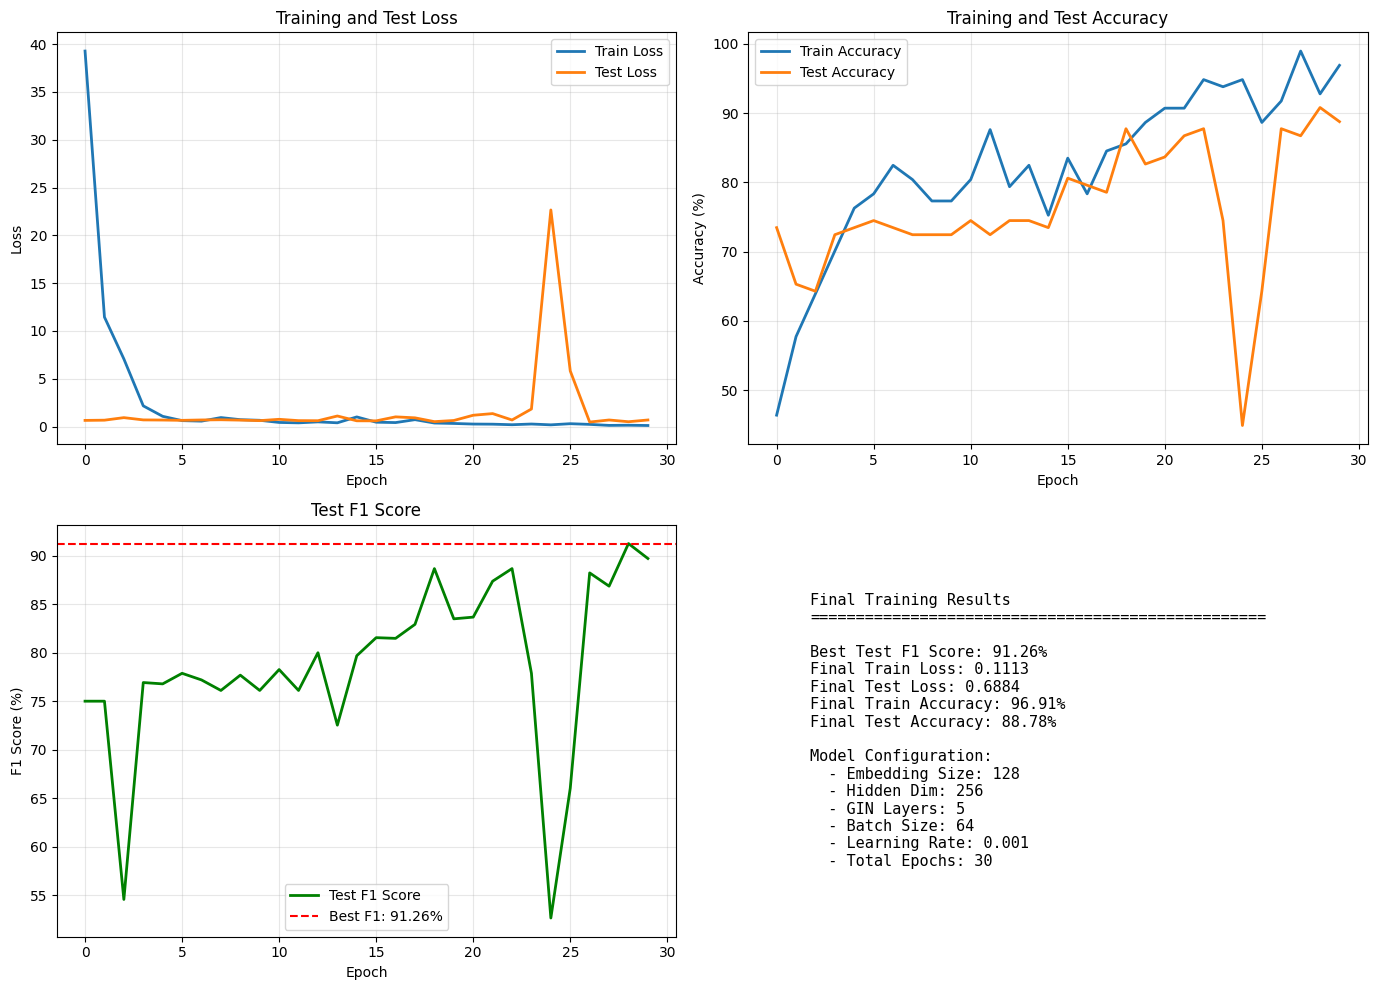

In [17]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accs, label='Test Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1 curve
axes[1, 0].plot(test_f1s, label='Test F1 Score', linewidth=2, color='green')
axes[1, 0].axhline(y=best_test_f1, color='r', linestyle='--', label=f'Best F1: {best_test_f1:.2f}%')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score (%)')
axes[1, 0].set_title('Test F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Summary statistics
axes[1, 1].axis('off')
summary_text = f"""
Final Training Results
{'='*50}

Best Test F1 Score: {best_test_f1:.2f}%
Final Train Loss: {train_losses[-1]:.4f}
Final Test Loss: {test_losses[-1]:.4f}
Final Train Accuracy: {train_accs[-1]:.2f}%
Final Test Accuracy: {test_accs[-1]:.2f}%

Model Configuration:
  - Embedding Size: {EMBEDDING_SIZE}
  - Hidden Dim: {HIDDEN_DIM}
  - GIN Layers: {NUM_LAYERS}
  - Batch Size: {BATCH_SIZE}
  - Learning Rate: {LEARNING_RATE}
  - Total Epochs: {NUM_EPOCHS}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Final Evaluation on Test Set

In [18]:
# Final evaluation with best model
print("Evaluating best model on test set...\n")
final_metrics = evaluate(model, test_loader, criterion, device)

print("="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"Accuracy:  {final_metrics['accuracy']:.2f}%")
print(f"Precision: {final_metrics['precision']:.2f}%")
print(f"Recall:    {final_metrics['recall']:.2f}%")
print(f"F1 Score:  {final_metrics['f1']:.2f}%")
print(f"AUC-ROC:   {final_metrics['auc']:.4f}")
print("="*70)

Evaluating best model on test set...



FINAL TEST SET RESULTS
Accuracy:  88.78%
Precision: 90.57%
Recall:    88.89%
F1 Score:  89.72%
AUC-ROC:   0.9535


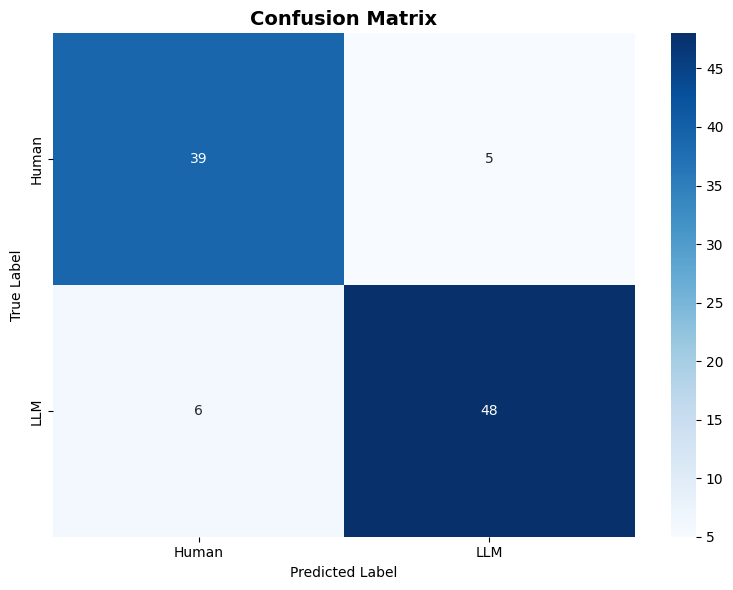


Confusion Matrix:
[[39  5]
 [ 6 48]]


In [19]:
# Confusion matrix
cm = confusion_matrix(final_metrics['labels'], final_metrics['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Human', 'LLM'],
            yticklabels=['Human', 'LLM'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)

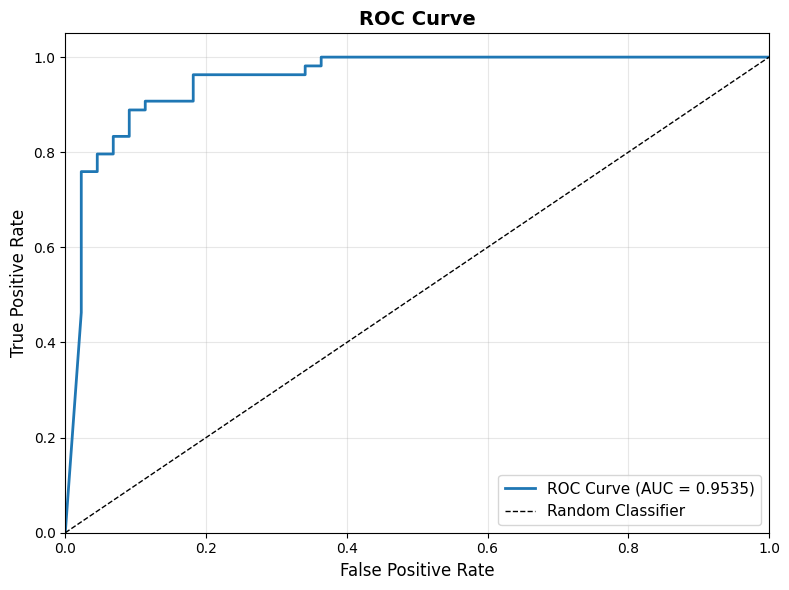

In [20]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(final_metrics['labels'], final_metrics['probabilities'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {final_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [21]:
# Analyze misclassifications
predictions = np.array(final_metrics['predictions'])
labels = np.array(final_metrics['labels'])
probabilities = np.array(final_metrics['probabilities'])

# Find misclassified samples
misclassified_idx = np.where(predictions != labels)[0]
correct_idx = np.where(predictions == labels)[0]

print(f"Total samples: {len(labels)}")
print(f"Correctly classified: {len(correct_idx)} ({100*len(correct_idx)/len(labels):.2f}%)")
print(f"Misclassified: {len(misclassified_idx)} ({100*len(misclassified_idx)/len(labels):.2f}%)")

# Breakdown by class
human_misclassified = np.where((predictions != labels) & (labels == 0))[0]
llm_misclassified = np.where((predictions != labels) & (labels == 1))[0]

print(f"\nMisclassified breakdown:")
print(f"  Human → LLM: {len(human_misclassified)} (false positives)")
print(f"  LLM → Human: {len(llm_misclassified)} (false negatives)")

Total samples: 98
Correctly classified: 87 (88.78%)
Misclassified: 11 (11.22%)

Misclassified breakdown:
  Human → LLM: 5 (false positives)
  LLM → Human: 6 (false negatives)


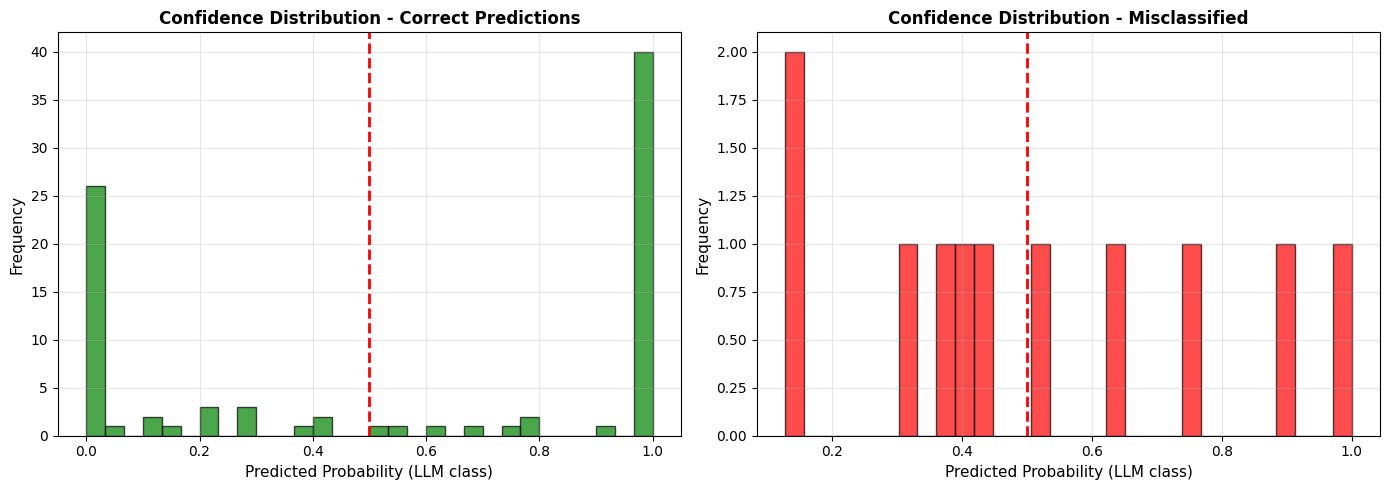

In [22]:
# Confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence for correct predictions
correct_probs = probabilities[correct_idx]
axes[0].hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Confidence Distribution - Correct Predictions', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Confidence for misclassified predictions
misclassified_probs = probabilities[misclassified_idx]
axes[1].hist(misclassified_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Confidence Distribution - Misclassified', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Model Saving and Summary

In [23]:
# Save complete model checkpoint
checkpoint = {
    'model_state_dict': best_model_state,
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_SIZE,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'max_nodes': MAX_NODES,
    'best_test_f1': best_test_f1,
    'final_metrics': final_metrics,
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accs': train_accs,
    'test_accs': test_accs,
    'test_f1s': test_f1s
}

torch.save(checkpoint, 'checkpoint.pth')
print("Complete checkpoint saved to 'checkpoint.pth'")

Complete checkpoint saved to 'checkpoint.pth'


In [24]:
# Save results summary
results_summary = {
    'model_config': {
        'embedding_size': EMBEDDING_SIZE,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'max_nodes': MAX_NODES,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    },
    'final_metrics': {
        'accuracy': float(final_metrics['accuracy']),
        'precision': float(final_metrics['precision']),
        'recall': float(final_metrics['recall']),
        'f1': float(final_metrics['f1']),
        'auc': float(final_metrics['auc'])
    },
    'confusion_matrix': cm.tolist(),
    'dataset_stats': {
        'train_size': len(valid_dataset),
        'test_size': len(test_dataset),
        'vocab_size': vocab_size
    }
}

with open('results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results summary saved to 'results_summary.json'")

Results summary saved to 'results_summary.json'


## 10. Sample Predictions

In [25]:
# Show some example predictions
num_examples = 5

print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

for i in range(min(num_examples, len(test_dataset))):
    sample = test_dataset[i]
    
    # Prepare inputs
    code_graph = sample['code_graph'].unsqueeze(0).to(device)
    contrast_graph = sample['contrast_graph'].unsqueeze(0).to(device)
    code_seq = [sample['code_sequence']]
    contrast_seq = [sample['contrast_sequence']]
    code_num_nodes = [sample['code_num_nodes']]
    contrast_num_nodes = [sample['contrast_num_nodes']]
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        logits = model(code_seq, code_graph, code_num_nodes,
                      contrast_seq, contrast_graph, contrast_num_nodes)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1).item()
        confidence = probs[0][pred].item()
    
    true_label = sample['label'].item()
    
    print(f"\nSample {i+1}:")
    print(f"  Index: {sample['index']}")
    print(f"  True Label: {true_label} ({'Human' if true_label == 0 else 'LLM'})")
    print(f"  Predicted: {pred} ({'Human' if pred == 0 else 'LLM'})")
    print(f"  Confidence: {confidence*100:.2f}%")
    print(f"  Code nodes: {sample['code_num_nodes']}, Contrast nodes: {sample['contrast_num_nodes']}")
    print(f"  {'✓ CORRECT' if pred == true_label else '✗ INCORRECT'}")


SAMPLE PREDICTIONS

Sample 1:
  Index: gp333488
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 100.00%
  Code nodes: 42, Contrast nodes: 38
  ✓ CORRECT

Sample 2:
  Index: gp254519
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 61.86%
  Code nodes: 26, Contrast nodes: 24
  ✓ CORRECT

Sample 3:
  Index: gp320381
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 100.00%
  Code nodes: 130, Contrast nodes: 264
  ✓ CORRECT

Sample 4:
  Index: gp162698
  True Label: 0 (Human)
  Predicted: 1 (LLM)
  Confidence: 90.87%
  Code nodes: 45, Contrast nodes: 55
  ✗ INCORRECT

Sample 5:
  Index: gp187093
  True Label: 1 (LLM)
  Predicted: 0 (Human)
  Confidence: 67.10%
  Code nodes: 43, Contrast nodes: 47
  ✗ INCORRECT
